## Example using constrained GP model
This is the code used to produce the 'corroded pipeline' example in the paper _'Gaussian processes with linear operator inequality constraints'_, https://arxiv.org/abs/1901.03134

### Imports

In [1]:
### Basic imports ###
import sys, os

# For plotting
import plotly
import plotly.plotly as pltly
import plotly.graph_objs as go
import plotly.offline as pltlyoff
from IPython.display import display, HTML

# This is for plotting as static images (to show on e.g. GitHub)
import plotly.io as pio
from IPython.display import Image

# Numerics
import numpy as np
import scipy as sp
import itertools
import pyDOE
import pandas as pd

### Custom files ###

# Path to custom plotly module 'GPPlotly' for plotting 
# can be downloaded at https://github.com/cagrell/gp_plotly
dir_GPPlotly = 'C:\\Data\\git repos\\gp_plotly\\'
sys.path.append(dir_GPPlotly) 

# Path to the constrained GP moule 
# can be downloaded at https://github.com/cagrell/gp_constr
dir_gp_constr = 'C:\\Data\\git repos\\gp_constr\\'
sys.path.append(dir_gp_constr) 

# Import
from GPPlotly.plottingfunctions import PlotGP2d, add_traces_to_fig, gp_diagnostics, pred_vs_error_perc
from GPConstr.model import kernel_RBF, GPmodel, Constraint

### Setup notebook ###
pltlyoff.init_notebook_mode(connected=True)
print('Python version', sys.version)

Loading constrained GP module from C:\Data\git repos\gp_constr
Loading R wrapper...
Running R from rpy2: R version 3.4.3 (2017-11-30)


Python version 3.6.3 (v3.6.3:2c5fed8, Oct  3 2017, 18:11:49) [MSC v.1900 64 bit (AMD64)]


## 1. Define function for generating synthetic test/training data
The simplified pipe burst capacity in RP-F101

$P_{cap}(\sigma_{u}, D, t, d, l) = 1.05\frac{2t \sigma_{u}}{D - t} \frac{1 - d/t}{1 - \frac{d/t}{Q}}$, $Q = \sqrt{1 + 0.31\frac{l^{2}}{Dt}}$

We have the following constraints

1.) $0 \leq P_{cap} \leq 1.05\frac{t \sigma_{u}}{D - t}$

2.) $\frac{\partial P_{cap}}{\partial \sigma_{u}} > 0$

3.) $\frac{\partial P_{cap}}{\partial D} < 0$

4.) $\frac{\partial P_{cap}}{\partial t} > 0$

5.) $\frac{\partial P_{cap}}{\partial d} < 0$

6.) $\frac{\partial P_{cap}}{\partial l} < 0$

for $\sigma_{u} \in [450, 550]$ (MPa), $t \in [5, 30]$ (mm), $D \in [10t, 50t]$ (mm), $d \in [0, t]$ (mm) and $l \in [0, 1000]$ (mm).

Let $\textbf{x}$ denote the transformed input vector $\textbf{x} = [x_{1}, \dots, x_{5}]$ where $x_{1} = (\sigma_{u} - 450)/(550-450)$, $x_{2} = (D/t - 10)/(50 - 10)$, $x_{3} = (t - 5)/(30-5)$, $x_{4} = d/t$ and $x_{5} = l/1000$.  

We will make use of the function

$f(\textbf{x}) = P_{cap}(\textbf{x})$ with the corresponding constraints

1.) $0 \leq f(\textbf{x}) \leq 1.05\frac{2t \sigma_{u}}{D - t}$ 
$= 1.05 \cdot 2\frac{x_{1}(550-450)+450}{x_{2}(50-10)+10}$
$= 10.5\frac{x_{1} + 9}{4x_{2} + 1}$

2.) $\frac{\partial f}{\partial x_{1}} > 0$

3.) $\frac{\partial f}{\partial x_{2}} < 0$

4.) $\frac{\partial f}{\partial x_{3}} > 0$

5.) $\frac{\partial f}{\partial x_{4}} < 0$

6.) $\frac{\partial f}{\partial x_{5}} < 0$

for $\textbf{x} \in [0, 1]^{5}$.


In [2]:
# Function to emulate/estimate
def burst_cap(su, D, t, d, l):
    """ 
    Simplified burst capacity equation in DNV GL RP-F101 
    
    Input:    
    su =  Ultimate tensile strength [MPa]
    D  =  Pipe diameter             [mm]
    t  =  Pipe wall thickness       [mm]
    d  =  Defect depth              [mm]
    l  =  Defect length             [mm]

    """
    
    p0 = 1.05*2*t*su/(D-t)               # Un-corroded capacity
    Q = np.sqrt(1 + 0.31*(l**2)/(D*t))   # Length factor
    d_t = d/t                            # Relative depth
    R = (1-d_t)/(1 - d_t/Q)              # Capacity reduction factor due to the defect
    
    p_cap = p0*R                         # Capacity of pipe with defect
    
    return p_cap

# Ranges of input variables
rng = {
    'su':(450, 550),
    't': (5, 30),
    'D_t': (10, 50),
    'd_t': (0, 1),
    'l': (0, 1000),
}

def phys_to_x(su, D, t, d, l):
    """ Transform from physical to standardized domain """
    
    x = np.array([
        (su - rng['su'][0])/(rng['su'][1] - rng['su'][0]),
        (D/t - rng['D_t'][0])/(rng['D_t'][1] - rng['D_t'][0]),
        (t - rng['t'][0])/(rng['t'][1] - rng['t'][0]),
        (d/t - rng['d_t'][0])/(rng['d_t'][1] - rng['d_t'][0]),
        (l - rng['l'][0])/(rng['l'][1] - rng['l'][0])
    ])
    
    return x

def x_to_phys(x):
    """ Transform from standardized to physical domain """
    su = x[0]*(rng['su'][1] - rng['su'][0]) + rng['su'][0]
    D_t = x[1]*(rng['D_t'][1] - rng['D_t'][0]) + rng['D_t'][0]
    t = x[2]*(rng['t'][1] - rng['t'][0]) + rng['t'][0]
    d_t = x[3]*(rng['d_t'][1] - rng['d_t'][0]) + rng['d_t'][0]
    l = x[4]*(rng['l'][1] - rng['l'][0]) + rng['l'][0]
    
    return su, D_t*t, t, d_t*t, l

def fun(x):
    """ function used to generate data """
    p_cap = burst_cap(*x_to_phys(x))
    return p_cap

def fun_mult(X):
    """ For multiple x in array X """
    return np.array([fun(X[i,:]) for i in range(X.shape[0])])

In [3]:
# Generate some samples to plot

data = []

for _ in range(1000):
    x = np.random.uniform(size = 5)
    y = fun(x)
    
    data.append(list(x_to_phys(x)) + [y])
    
df = pd.DataFrame(data)
df.columns = ['su', 'D', 't', 'd', 'l', 'y_true']
#df['y_mean'] = df['y_true'] 
#df['y_var'] = np.ones(df.shape[0])*0.001
df['D_t'] = df['D'] / df['t'] 

df.head()

,su,D,t,d,l,y_true,D_t
0,544.578796,860.498568,25.802474,11.327495,673.330799,23.670298,33.349459
1,546.345297,284.525064,9.746441,9.683797,266.866033,0.391509,29.192715
2,534.987965,201.648335,9.988868,5.382074,907.860047,28.355433,20.187307
3,531.455148,250.842783,13.261557,12.707819,93.949811,8.963653,18.915033
4,541.079727,154.137768,5.478323,0.394400,806.193392,39.040156,28.135942


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000215F0C924E0>]],
      dtype=object)

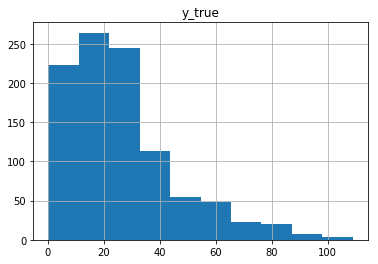

In [4]:
# Histogram of output
%matplotlib inline
df.hist(column = 'y_true')

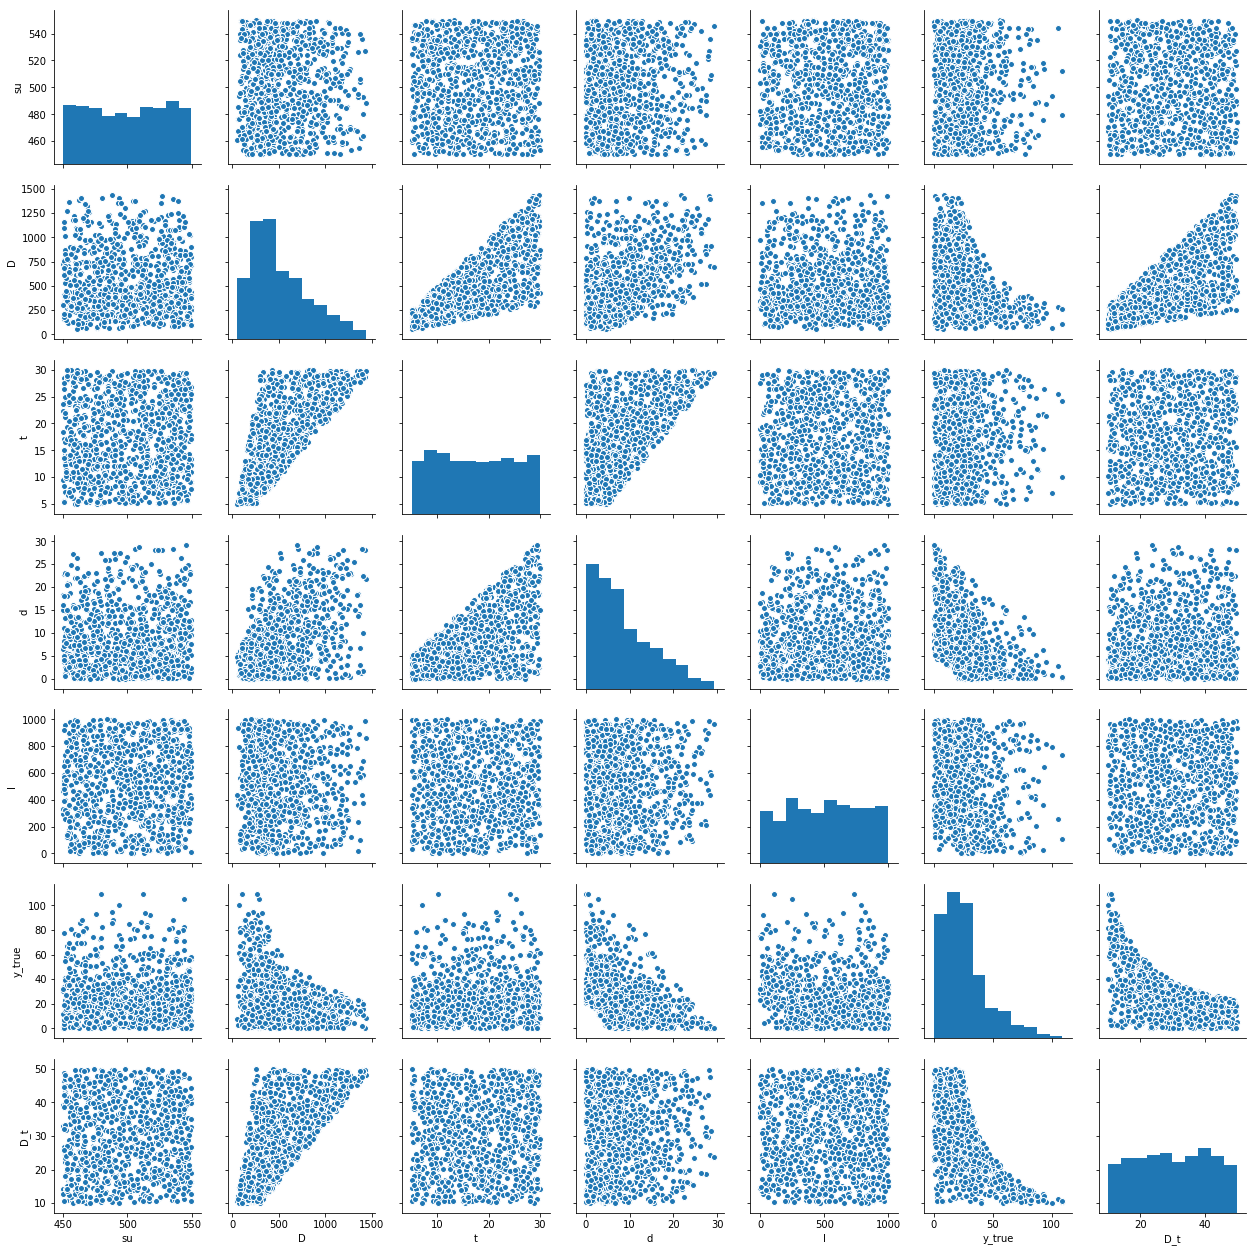

In [5]:
import seaborn as sns

sns.pairplot(df[df['y_true'] < 400])

## 2. Emulation (no noise) in $\mathbb{R}^{4}$

### 2.1. Generate synthetic training data

In [6]:
# Design data - no noise
n_samples = 20
input_dim = 5

x_design = pyDOE.lhs(input_dim, samples = n_samples, criterion = 'maximin', iterations = 1000)
y_design = fun_mult(x_design)

### 2.2. Define GP model (without constraints)

In [24]:
# Set up model
ker = kernel_RBF(variance = 1, lengthscale = [1]*input_dim)
model = GPmodel(kernel = ker, likelihood = 1E-6, mean = 0) # No Noise

# Training data
model.X_training = x_design
model.Y_training = y_design

In [25]:
# Optimize
model.optimize(include_constraint = False, fix_likelihood = True)
print(model)

..Running optimization for unconstrained GP ... DONE - Total time: 0.236 seconds
----- GP model ----- 
 mean = 0 
 likelihood = 1e-06 
 kernel: 
   type = RBF 
   input dim = 5 
   lenghtscale = [ 10.60864102   0.31019527 206.00301518   0.82080633   8.7211842 ] 
   variance = 1724.3707593038484 
 constraint: 
   No constraints 
---------------------


#### Test the unconstrained model 

In [9]:
# Helper function - put test data in dataframe
def get_diagnostics_df(x_test, y_test, mean, var):
    df = pd.DataFrame(x_test)
    df.columns = ['x' + str(i+1) for i in range(x_test.shape[1])]
    df['y_true'] = y_test
    df['y_mean'] = mean
    df['y_var'] = var
    
    return df

In [10]:
# Test data
n_test = 100
x_test = np.random.rand(n_test, input_dim) # Uniform samples
y_test = fun_mult(x_test)

# Run unconstrained model
mean_unconstr, var_unconstr = model.calc_posterior_unconstrained(x_test, full_cov = False)
mean_unconstr = np.array(mean_unconstr).flatten()
var_unconstr = np.array(var_unconstr).flatten()

# Collect data in df
df_unconstr = get_diagnostics_df(x_test, y_test, mean_unconstr, var_unconstr)


..Running calculation of K_w ... SKIP - (cached)
..Running calculation of Cholesky factor for K_w ... SKIP - (cached)
..Calculating f* | Y ... DONE - Total time: 0.003 seconds


In [11]:
# View first couple of records of dataframe with testing data
df_unconstr.head()

,x1,x2,x3,x4,x5,y_true,y_mean,y_var
0,0.648436,0.693823,0.749069,0.764025,0.465743,11.096449,11.614768,1.582215
1,0.190255,0.656725,0.643793,0.442729,0.112977,25.798646,21.936827,3.009180
2,0.104303,0.535856,0.687962,0.434870,0.694078,20.716054,21.582158,0.023730
3,0.699200,0.689163,0.113101,0.639479,0.237112,13.772938,17.194006,2.748303
4,0.460698,0.691255,0.974797,0.822127,0.672304,7.858364,7.737374,1.037818


In [12]:
# Plot diagnostics
figs = gp_diagnostics(df_unconstr, y_name = 'y', subplots = True)
for fig in figs:
    pltlyoff.iplot(fig, filename='')

#### Plot a 1D slice of the model

In [13]:
plot_x_dim = 2 # Dimension to plot
x_base_val = 0.5 # All other x has this value

# Test input
px_test = np.linspace(0, 1, 100)
px_test_arr = np.ones((len(px_test), input_dim))*x_base_val
px_test_arr[:,plot_x_dim] = px_test

# True function
y_true = fun_mult(px_test_arr)

# From GP
mean_unconstr, cov_unconstr = model.calc_posterior_unconstrained(px_test_arr, full_cov = True)
mean_unconstr = np.array(mean_unconstr).flatten()
var_unconstr = np.diagonal(cov_unconstr)

num_samples = 10
show_samplepaths = True
samplepaths_unconstr = []
if show_samplepaths: samplepaths_unconstr = np.random.multivariate_normal(mean_unconstr, cov_unconstr, num_samples).T

fig_unconstr_slice = PlotGP2d(x_mean = px_test, mean = mean_unconstr, var = var_unconstr,
                        x_true = px_test, y_true = y_true,
                        samplepaths = samplepaths_unconstr,
                        title = 'f(x) as a function of x[{0}] where x[i] = {1} for i != {0}'.format(plot_x_dim, x_base_val), xrange = [0, 1], smoothing = False)

pltlyoff.iplot(fig_unconstr_slice, filename='')

..Running calculation of K_w ... SKIP - (cached)
..Running calculation of Cholesky factor for K_w ... SKIP - (cached)
..Calculating f* | Y ... DONE - Total time: 0.005 seconds


### 2.2.3. Include the constraints

In [14]:
def constant_function(val):
    """ Return the constant function"""
    def fun(x):
        return np.array([val]*x.shape[0])
    
    return fun

In [26]:
# Create derivative constraints
constr_deriv = [
    Constraint(LB = constant_function(0), UB = constant_function(float('Inf'))),
    Constraint(LB = constant_function(float('-Inf')), UB = constant_function(0)),
    Constraint(LB = constant_function(0), UB = constant_function(float('Inf'))),
    Constraint(LB = constant_function(float('-Inf')), UB = constant_function(0)),
    Constraint(LB = constant_function(float('-Inf')), UB = constant_function(0))
]

In [27]:
# Add constraints to model
model.constr_deriv = constr_deriv
model.constr_likelihood = 1E-3

In [28]:
print(model)

----- GP model ----- 
 mean = 0 
 likelihood = 1e-06 
 kernel: 
   type = RBF 
   input dim = 5 
   lenghtscale = [ 10.60864102   0.31019527 206.00301518   0.82080633   8.7211842 ] 
   variance = 1724.3707593038484 
 constraint: 
   df/dx_1 [0], df/dx_2 [0], df/dx_3 [0], df/dx_4 [0], df/dx_5 [0] 
   constr_likelihood = 0.001 
---------------------


In [271]:
# Search for a suitable set of virtual observation locations where the constraint is imposed
df = model.find_XV_subop(bounds =  [(0.001, 1)]*input_dim, p_target = 0.9, 
                         max_iterations = 3,
                         min_prob_unconstr_xv = -1, opt_method = 'differential_evolution')

Searching for points XV s.t. P(a - nu < Lf < b + nu) > p_target = 0.9 for Lf = [df/dx_1, df/dx_2] and nu = 0.0012815515655446004 ...
i = 2, XV[1] = [0.69508521 0.001      0.4691333  0.77952802 0.001     ], prob = 0.013915737393918638, acc. rate = 7.743114634602288e-10, optimization time = 21.654 seconds
i = 1, XV[2] = [0.39891604 0.86280969 0.90215136 0.2422365  0.67876184], prob = 0.01222908745030655, acc. rate = 7.743114634602288e-10, optimization time = 6.461 seconds
i = 1, XV[3] = [0.12217503 0.001      0.43952115 1.         1.        ], prob = 0.18395476948235384, acc. rate = 2.3030147340782664e-13, optimization time = 6.494 seconds
DONE - Found 3 points. Min. constraint prob = 0.18395476948235384. Total time spent = 1 minutes 7.7 seconds


In [272]:
# Search for a suitable set of virtual observation locations where the constraint is imposed
df = model.find_XV_subop(bounds =  [(0.001, 1)]*input_dim, p_target = 0.9, 
                         max_iterations = 3, moment_approximation = True,
                         min_prob_unconstr_xv = -1, opt_method = 'differential_evolution')

Searching for points XV s.t. P(a - nu < Lf < b + nu) > p_target = 0.9 for Lf = [df/dx_1, df/dx_2] and nu = 0.0012815515655446004 ...
i = 1, XV[1] = [0.001      1.         0.65080488 0.19516938 1.        ], prob = 0.07282482554217751, acc. rate = 4.7674182411124824e-14, optimization time = 23.469 seconds
i = 1, XV[2] = [0.59972426 1.         0.74366301 0.23854417 0.001     ], prob = 0.08211707335179085, acc. rate = 4.7674182411124824e-14, optimization time = 5.811 seconds
i = 2, XV[3] = [0.63385866 0.20229282 0.57570211 0.83245013 0.16913378], prob = 0.07101887147709474, acc. rate = 9.495542581702195e-15, optimization time = 6.139 seconds
DONE - Found 3 points. Min. constraint prob = 0.07101887147709474. Total time spent = 1 minutes 9.5 seconds


In [29]:
# Define seed-set of virtual observation locations 
# (same set for all constraints in this case)
x_seed = pyDOE.lhs(input_dim, samples = 40, criterion = 'maximin', iterations = 1000)
for constr in model.constr_deriv:
    constr.Xv = x_seed

print(model)

----- GP model ----- 
 mean = 0 
 likelihood = 1e-06 
 kernel: 
   type = RBF 
   input dim = 5 
   lenghtscale = [ 10.60864102   0.31019527 206.00301518   0.82080633   8.7211842 ] 
   variance = 1724.3707593038484 
 constraint: 
   df/dx_1 [40], df/dx_2 [40], df/dx_3 [40], df/dx_4 [40], df/dx_5 [40] 
   constr_likelihood = 0.001 
---------------------


In [21]:
print(model)

----- GP model ----- 
 mean = 0 
 likelihood = 1e-06 
 kernel: 
   type = RBF 
   input dim = 5 
   lenghtscale = [1.e-06 1.e-06 1.e-06 1.e-06 1.e-06] 
   variance = 1e-06 
 constraint: 
   df/dx_1 [40], df/dx_2 [40], df/dx_3 [40], df/dx_4 [40], df/dx_5 [40] 
   constr_likelihood = 0.001 
---------------------


In [30]:
# Optimize hyperparameters
#model.optimize(include_constraint = True, fix_likelihood = True, n = 10)
#opt_args = {'options' : {'maxtime ':10}}
opt_args = {}
model._optimize_constrained(fix_likelihood = True, opt_method = 'shgo', algorithm = 'minimax_tilting', n = 10, opt_args = opt_args)
print(model)

..Running optimization for constrained GP - max P(Y, C) ...

C:\Data\git repos\gp_constr\GPConstr\model.py:837: RuntimeWarning:

divide by zero encountered in log



 DONE - Total time: 11.087 seconds
----- GP model ----- 
 mean = 0 
 likelihood = 1e-06 
 kernel: 
   type = RBF 
   input dim = 5 
   lenghtscale = [ 10.60864152   0.31019577 206.00301568   0.82080683   8.7211847 ] 
   variance = 8621.853797019243 
 constraint: 
   df/dx_1 [40], df/dx_2 [40], df/dx_3 [40], df/dx_4 [40], df/dx_5 [40] 
   constr_likelihood = 0.001 
---------------------


In [31]:
# Print constraint probability P(C)
model.constrprob_Xv(n = 10)

6.145924095335037e-12

#### Test the constrained model 

In [32]:
percentiles = [0.025, 0.5, 0.975]
mean, var, perc, mode, samples = model.calc_posterior_constrained(x_test, compute_mode = False, num_samples = 1000, save_samples = 30, algorithm = 'minimax_tilting', resample = False)
mean = np.array(mean).flatten()
lower = perc[0]
upper = perc[2]
var = np.array(var).flatten()

..Running calculation of K_w ... SKIP - (cached)
..Running calculation of Cholesky factor for K_w ... SKIP - (cached)
..Running preparation step 1 - dependence on (XS, X) ... DONE - time: 0.003 seconds
..Running preparation step 2 - dependence on (XV, X) ... SKIP - (cached)
..Running preparation step 3 - dependence on (XS, XV, X) ... DONE - time: 0.007 seconds
..sampling 1000 times from truncated constraint distribution C~|C, Y DONE - time: 20.501 seconds
..sampling 1000 times from constrained GP f*|C, Y DONE - time: 0.013 seconds
..computing statistics from samples DONE - time: 0.005 seconds
 DONE - Total time: 20.532 seconds


In [33]:
fig = pred_vs_error_perc(mean, lower, upper, y_test, 95)
pltlyoff.iplot(fig, filename='')

In [ ]:
# Show plot as static image
Image(pio.to_image(fig, width=700, height=500, scale=1, format='png'))

#### Plot a 1D slice of the constrained model

In [277]:
# Plot constrained
mean, var, perc, mode, samples = model.calc_posterior_constrained(px_test_arr, compute_mode = False, num_samples = 1000, algorithm = 'minimax_tilting', resample = False)

p_lower = perc[0]
p_upper = perc[2]
p_label = '[p{}, p{}] conf.'.format(10, 90)

samplepaths_Z = []
if show_samplepaths: 
    samplepaths_Z = np.array(samples)

fig_constrained_1 = PlotGP2d(x_mean = px_test, mean = np.array(mean).flatten(),
                        samplepaths =  samplepaths_Z,
                        x_true = px_test, y_true = y_true,
                        p_lower = p_lower, p_upper = p_upper, p_label = p_label,
                        title = 'f(x) as a function of x[{0}] where x[i] = {1} for i != {0}'.format(plot_x_dim, x_base_val))

pltlyoff.iplot(fig_constrained_1, filename='')

..Running calculation of K_w ... SKIP - (cached)
..Running calculation of Cholesky factor for K_w ... SKIP - (cached)
..Running preparation step 1 - dependence on (XS, X) ... DONE - time: 0.000 seconds
..Running preparation step 2 - dependence on (XV, X) ... SKIP - (cached)
..Running preparation step 3 - dependence on (XS, XV, X) ... DONE - time: 0.000 seconds
..using old samples from truncated constraint distribution C~|C, Y
..sampling 1000 times from constrained GP f*|C, Y DONE - time: 0.042 seconds
..computing statistics from samples DONE - time: 0.004 seconds
 DONE - Total time: 0.047 seconds


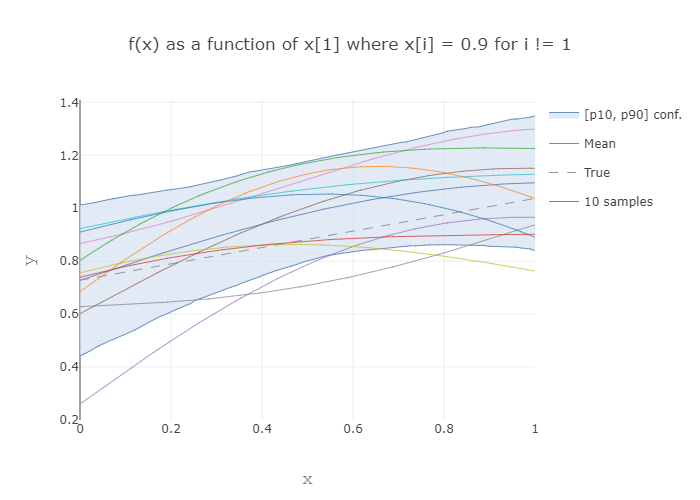

In [21]:
# Show plot as static image
Image(pio.to_image(fig_constrained_1, width=700, height=500, scale=1, format='png'))